## pseudo labeling MASK from a model

In [1]:
config_file = '/opt/ml/input/level2-semantic-segmentation-level2-cv-10/mmsegmentation/configs/_hajun_/beit/upernet_beit-large_fp16_8x1_640x640_160k_ade20k.py'
checkpoint_file = '/opt/ml/input/data/work_dirs/upernet_beit-large_fp16_8x1_640x640_160k_ade20k/epoch_42.pth'

batch_size = 8

In [2]:
import argparse
import os
import os.path as osp
import shutil
import time
import warnings
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

#!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Patch

import webcolors
plt.rcParams['axes.grid'] = False

import mmcv
import torch
from torch.utils.data import Dataset, DataLoader
from mmcv import Config
from mmcv.cnn.utils import revert_sync_batchnorm
from mmcv.parallel import MMDataParallel, MMDistributedDataParallel
from mmcv.runner import (get_dist_info, init_dist, load_checkpoint,
                         wrap_fp16_model)
from mmcv.utils import DictAction

from mmseg import digit_version
from mmseg.apis import multi_gpu_test, single_gpu_test, inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.datasets import build_dataloader, build_dataset
from mmseg.models import build_segmentor
from mmseg.utils import setup_multi_processes
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
class_colormap = pd.read_csv("./class_dict.csv")

def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

def plot_examples(batch_size, batch_idx, mode):
    category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    if mode == 'val':
        with torch.no_grad():
            for index, infos in enumerate(data_loader):
                if index != batch_idx:
                    continue
                multi_512_idx = 0 if len(infos['img'])==1 else len(infos['img'])//2
                fig, ax = plt.subplots(nrows=batch_size, ncols=3, figsize=(12, 4*batch_size), constrained_layout=True)
                for i in range(batch_size):
                    img = infos['img'][multi_512_idx][i]
                    mask = infos['gt_semantic_seg'][multi_512_idx][i]
                    # print(mask.shape)
                    ax[i][0].imshow(torch.stack([img[0]*58.395 + 123.675,img[1]*57.12+116.28,img[2]*57.375+103.53]).type(torch.LongTensor).permute((1,2,0)))
                    ax[i][0].set_title(f"Orignal Image")
                    ax[i][1].imshow(label_to_color_image(mask.detach().cpu().numpy().squeeze()))
                    ax[i][1].set_title(f"Ground Truth")
                    ax[i][2].imshow(label_to_color_image(val_results[batch_size*batch_idx+i]))
                    ax[i][2].set_title(f"Pred Mask")
                    ax[i][2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
                plt.show()
    elif mode == 'test':
        with torch.no_grad():
            for index, infos in enumerate(test_data_loader):
                if index != batch_idx:
                    continue
                multi_512_idx = 0 if len(infos['img'])==1 else len(infos['img'])//2
                fig, ax = plt.subplots(nrows=batch_size, ncols=2, figsize=(12, 4*batch_size), constrained_layout=True)
                for i in range(batch_size):
                    img = infos['img'][multi_512_idx][i]
                    # print(mask.shape)
                    ax[i][0].imshow(torch.stack([img[0]*58.395 + 123.675,img[1]*57.12+116.28,img[2]*57.375+103.53]).type(torch.LongTensor).permute((1,2,0)))
                    ax[i][0].set_title(f"Orignal Image")
                    ax[i][1].imshow(label_to_color_image(test_results[batch_size*batch_idx+i]))
                    ax[i][1].set_title(f"Pred Mask")
                    ax[i][1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
                print(infos['img_metas'])
                plt.show()

In [4]:
cfg = Config.fromfile(config_file)
device = "cuda" if torch.cuda.is_available() else "cpu"
if cfg.get('cudnn_benchmark', False):
    torch.backends.cudnn.benchmark = True

cfg.gpu_ids = range(1)
cfg.model.pretrained = None
cfg.data.test.test_mode = True

test_dataset = build_dataset(cfg.data.test)
# The default loader config
loader_cfg = dict(
    # cfg.gpus will be ignored if distributed
    num_gpus=len(cfg.gpu_ids),
    shuffle=False)
# The overall dataloader settings
loader_cfg.update({
    k: v
    for k, v in cfg.data.items() if k not in [
        'train', 'val', 'test', 'train_dataloader', 'val_dataloader',
        'test_dataloader'
    ]
})
test_loader_cfg = {
    **loader_cfg,
    'samples_per_gpu': batch_size,
    'shuffle': False,  # Not shuffle by default
    **cfg.data.get('test_dataloader', {})
}
# build the dataloader
test_data_loader = build_dataloader(test_dataset, **test_loader_cfg)
cfg.model.train_cfg = None

model = build_segmentor(cfg.model, test_cfg=cfg.get('test_cfg'))
checkpoint = load_checkpoint(model, checkpoint_file, map_location='cpu')
model = MMDataParallel(model, device_ids= cfg.gpu_ids)
model.eval()

# inference 수행
test_results = single_gpu_test(model, test_data_loader)

2022-05-10 15:32:15,982 - mmseg - INFO - Loaded 624 images
/opt/conda/lib/python3.8/site-packages/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


load checkpoint from local path: /opt/ml/input/data/work_dirs/upernet_beit-large_fp16_8x1_640x640_160k_ade20k/epoch_42.pth
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 624/624, 4.9 task/s, elapsed: 127s, ETA:     0s

[DataContainer([[{'filename': '/opt/ml/input/data/mmseg/images/test/0191.jpg', 'ori_filename': '0191.jpg', 'ori_shape': (512, 512, 3), 'img_shape': (512, 512, 3), 'pad_shape': (512, 512, 3), 'scale_factor': array([1., 1., 1., 1.], dtype=float32), 'flip': False, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}, {'filename': '/opt/ml/input/data/mmseg/images/test/0192.jpg', 'ori_filename': '0192.jpg', 'ori_shape': (512, 512, 3), 'img_shape': (512, 512, 3), 'pad_shape': (512, 512, 3), 'scale_factor': array([1., 1., 1., 1.], dtype=float32), 'flip': False, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}}, {'filename': '/opt/ml/input/data/mmseg/images/test/0193.jpg', 'ori_filename': '0193.jpg', 'ori_shape': (512, 512, 3), 'img_shape': 

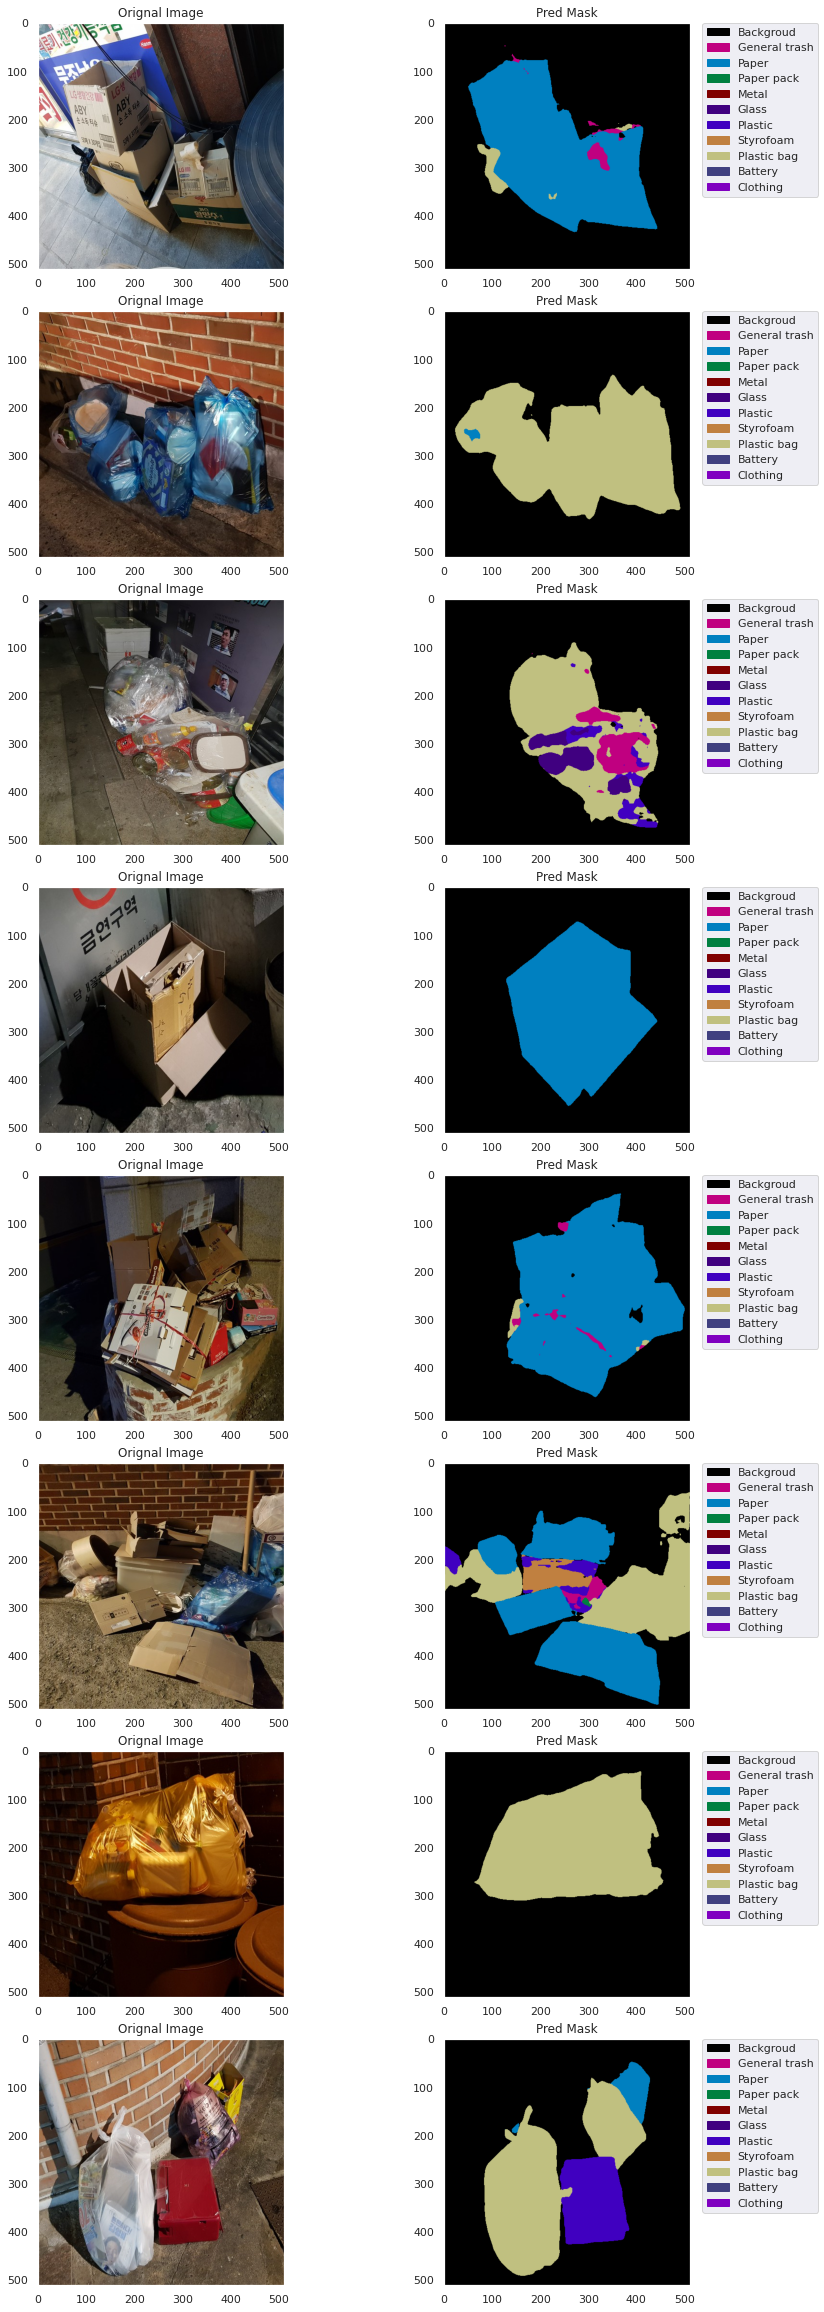

In [8]:
# batch_idx 를 바꿔가며 결과 확인
plot_examples(batch_size=batch_size, batch_idx=24, mode='test')

In [19]:
test_annotation ='../data/mmseg/annotations/test/'

In [26]:
transform = A.Compose([A.Resize(512, 512)])
preds_array = np.empty((0, 512*512), dtype=np.long)
with torch.no_grad():
    for index, infos in enumerate(tqdm(test_data_loader)):
        multi_512_idx = 0 if len(infos['img'])==1 else len(infos['img'])//2
        imgs = infos['img'][multi_512_idx]
        masks = np.array(test_results)[index*batch_size:(index+1)*batch_size]
        temp_mask = []
        for idx, mask in enumerate(masks):
            transformed = transform(image=img, mask=mask)
            mask = transformed['mask']
            idx = str(index*batch_size + idx)
            while len(idx) < 4: idx = '0' + idx
            cv2.imwrite(test_annotation+f'{idx}.png', mask)
   

100%|██████████| 78/78 [20:54<00:00, 16.08s/it]


In [ ]:
def decode(rle_mask):
    # print(rle_mask)
    mask = rle_mask.split()
    # print(mask)
    img = np.zeros(256*256, dtype=np.uint8)
    for i, m, in enumerate(mask):
        img[i] = int(m)
    return img.reshape(256,256)

학습시 
각자의 custom dataset python file 에서 

['images/training_all', 'images/test'],

이런식으로 뒤에 추가해주시면 됩니다! 

## output.csv to pseudo labeling MASK (ensemble)

In [ ]:
df = pd.read_csv('output.csv')

test_path = '../data/mmseg/images/test/'
ann_path = '../data/mmseg/annotations/test/'


for i in range(len(df)):      
    tmp_mask = (df.loc[i,'PredictionString']).split()

    mask = np.zeros(512*512, dtype='int16')

    for i, m, in enumerate(tmp_mask):
        mask[i] = int(m)
    mask = mask.reshape(256,256)
    mask = cv2.resize(mask, (512,512), interpolation=cv2.INTER_NEAREST)
    
    cv2.imwrite(ann_path+f'{i}.png', mask)